In [ ]:

!pip uninstall qiskit qiskit_machine_learning qiskit_aer
!pip install qiskit==0.43.3 qiskit_machine_learning==0.6.1 qiskit_aer==0.12.2

Found existing installation: qiskit 0.43.3
Uninstalling qiskit-0.43.3:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/qiskit-0.43.3.dist-info/*
Proceed (Y/n)? Y
  Successfully uninstalled qiskit-0.43.3
Found existing installation: qiskit-machine-learning 0.6.1
Uninstalling qiskit-machine-learning-0.6.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/qiskit_machine_learning-0.6.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/qiskit_machine_learning/*
Proceed (Y/n)? Y
  Successfully uninstalled qiskit-machine-learning-0.6.1
Found existing installation: qiskit-aer 0.12.2
Uninstalling qiskit-aer-0.12.2:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/qiskit_aer-0.12.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/qiskit_aer.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.11/dist-packages/qiskit_aer.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/qiskit_aer.libs/libopenblas-r0-f650aae0.3.3.so


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from qiskit import QuantumCircuit, Aer, execute
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from qiskit import QuantumCircuit, Aer, execute

In [ ]:
train_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_train.xlsx')
test_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_test.xlsx')

# Combine
full_df = pd.concat([train_df, test_df], ignore_index=True)
X_full = full_df.drop(columns=['Label'])
y_full = full_df['Label']

In [ ]:
le = LabelEncoder()
y_full = le.fit_transform(y_full)

In [ ]:
NUM_FEATURES = 5
TRAIN_SIZE = 100
TEST_RATIO = 0.25

selected_features = X_full.columns[:NUM_FEATURES]
X_full = X_full[selected_features]

sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, test_size=int(TEST_RATIO * TRAIN_SIZE), random_state=42)
for train_idx, test_idx in sss.split(X_full, y_full):
    X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
    y_train, y_test = y_full[train_idx], y_full[test_idx]

In [ ]:
def build_qnb_circuit(feature_vector, feature_qubits):
    qc = QuantumCircuit(feature_qubits)
    for i in range(feature_qubits):
        qc.ry(feature_vector[i], i)
    qc.measure_all()
    return qc

def estimate_probability(qc):
    backend = Aer.get_backend("qasm_simulator")
    shots = 1024
    job = execute(qc, backend=backend, shots=shots)
    counts = job.result().get_counts()
    zero_state = '0' * qc.num_qubits
    prob = counts.get(zero_state, 0) / shots
    return prob

In [ ]:
def train_qnb(X_train, y_train):
    class_probabilities = defaultdict(float)
    likelihoods = defaultdict(lambda: defaultdict(float))
    feature_qubits = X_train.shape[1]

    class_counts = Counter(y_train)
    total_samples = len(y_train)

    for c in class_counts:
        class_probabilities[c] = class_counts[c] / total_samples

    for i in range(len(X_train)):
        feature_vector = X_train.iloc[i].values
        label = y_train[i]

        qc = build_qnb_circuit(feature_vector, feature_qubits)
        likelihood = estimate_probability(qc)
        likelihoods[label][i] = likelihood

    return class_probabilities, likelihoods

In [ ]:
def predict_qnb(X_test, class_probabilities, likelihoods):
    predictions = []
    feature_qubits = X_test.shape[1]

    for i in range(len(X_test)):
        feature_vector = X_test.iloc[i].values
        qc = build_qnb_circuit(feature_vector, feature_qubits)
        test_likelihood = estimate_probability(qc)

        scores = {}
        for label in class_probabilities:
            # Average all likelihoods from training
            train_likelihoods = list(likelihoods[label].values())
            avg_likelihood = np.mean(train_likelihoods)

            scores[label] = class_probabilities[label] * np.exp(-abs(test_likelihood - avg_likelihood))

        predicted = max(scores, key=scores.get)
        predictions.append(predicted)

    return predictions

In [ ]:
class_probs, class_likelihoods = train_qnb(X_train, y_train)
y_pred = predict_qnb(X_test, class_probs, class_likelihoods)

acc = accuracy_score(y_test, y_pred)
print(f"\n🔍 QNB Accuracy: {acc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


🔍 QNB Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        25

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



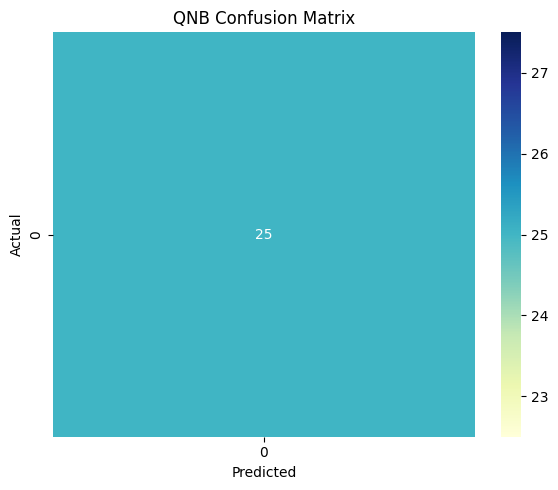

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("QNB Confusion Matrix")
plt.tight_layout()
plt.show()

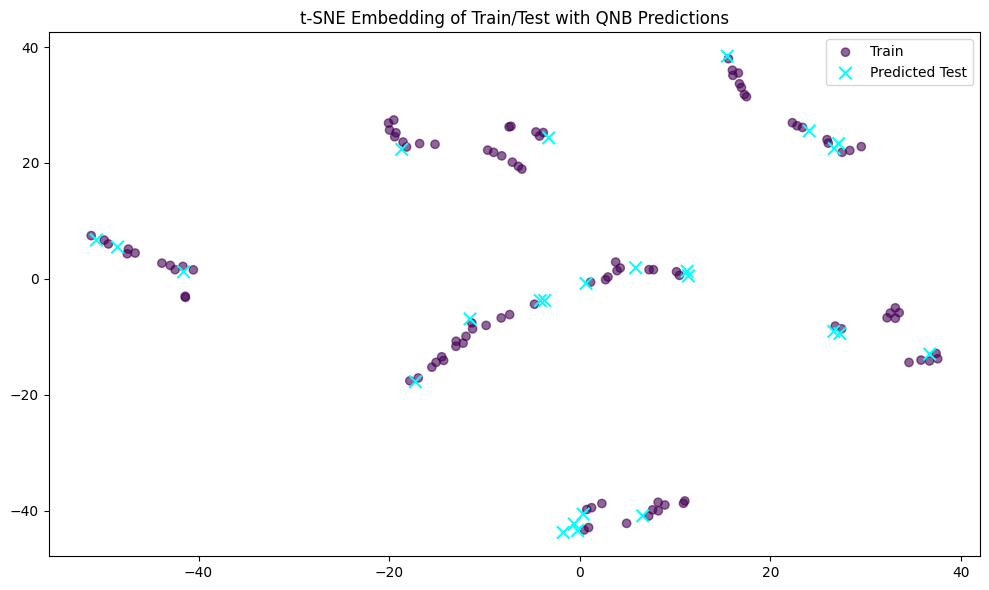

In [ ]:
X_all = pd.concat([X_train, X_test])
y_all = np.concatenate([y_train, y_test])

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_embedded = tsne.fit_transform(X_all)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:len(X_train), 0], X_embedded[:len(X_train), 1], c=y_train, cmap='viridis', label='Train', alpha=0.6)
plt.scatter(X_embedded[len(X_train):, 0], X_embedded[len(X_train):, 1], c=y_pred, cmap='cool', label='Predicted Test', marker='x', s=80)
plt.legend()
plt.title("t-SNE Embedding of Train/Test with QNB Predictions")
plt.tight_layout()
plt.show()

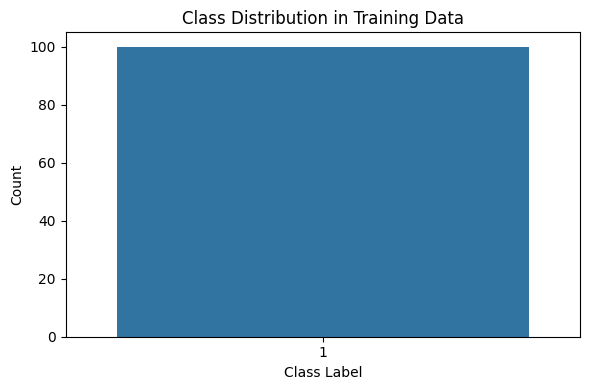

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

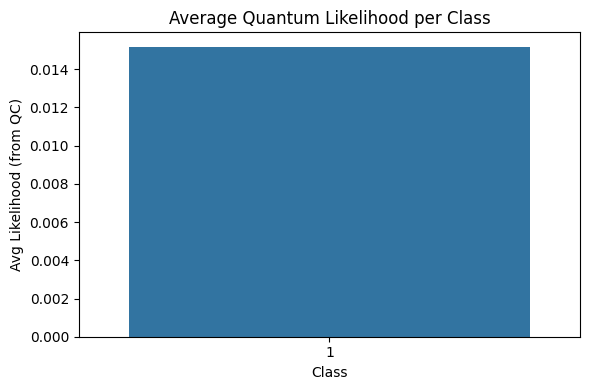

In [ ]:
avg_likelihoods = {label: np.mean(list(class_likelihoods[label].values())) for label in class_likelihoods}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(avg_likelihoods.keys()), y=list(avg_likelihoods.values()))
plt.title("Average Quantum Likelihood per Class")
plt.xlabel("Class")
plt.ylabel("Avg Likelihood (from QC)")
plt.tight_layout()
plt.show()

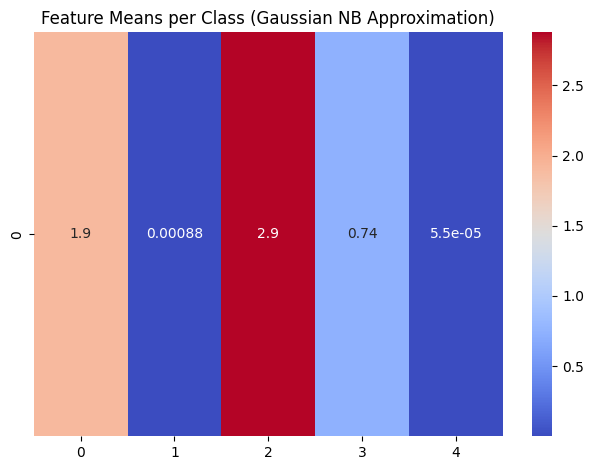

In [ ]:
import shap
shap_values = gnb.theta_
sns.heatmap(shap_values, annot=True, cmap='coolwarm')
plt.title("Feature Means per Class (Gaussian NB Approximation)")
plt.tight_layout()
plt.show()